2019/5/12  
m0, C0の推定も上手くいかなかったので、m0だけでも当てにいく

## ローカルトレンドモデル

2次の多項式モデル、線形のトレンドを掴みます。  

$$
x_t = 
\begin{bmatrix}
 x_{t}^2 \\
 x_{t}^1 \\
\end{bmatrix}, 
G = 
\begin{bmatrix}
 1 & 1 \\
 0 & 1 \\
\end{bmatrix},
F = 
\begin{bmatrix}
 1 & 0\\
\end{bmatrix}
W = 
\begin{bmatrix}
 w_2 & 0 \\
 0 & w_1 \\
\end{bmatrix}, 
V = V \\
x_t = G x_{t-1} + w_t, w_t \sim N(0, W) \\
y_t = F x_t + v_t, v_t \sim N(0, V)
$$

$x_t^{2}$は短時間でのレベル, $x_t^{1}$は短時間での傾きを表しています。  
状態$x$は、時点tが増えるにつれ係数$G$がかかり、状態が遷移していきます。  
状態が遷移する度に、多変量正規分布に従うノイズ$W$が混ざります。  
時点tの観測値$y_t$は、観測方程式に従って求められます。  
観測値$y_t$には、正規分布に従う観測ノイズ$v$が混ざります。  
$G_t, F_t$は既知であるとしますが、$W, V, x_0$は未知のままで大丈夫です、ギブスサンプリングで近似します。  
これにより、初期パラメータの恣意的な設定による結果の揺らぎを抑えます。

## ギブスサンプリング

条件付き事後分布を用いて状態やパラメータを近似的に解くアルゴリズムです。  
今回の場合は、状態$x_{0:T}$とパラメータ$\theta$を交互に固定した場合の、条件付き事後分布を用います。

0. $\theta^0$を準備  
1. 時点1 - Iで以下をサンプリング    
 1. $x_{0:T}^{i} \sim p(x_{0:T} | \theta^{i-1}, y_{1:T})$  
 2.  $\theta^{i} \sim p(\theta | x_{0:T}^i, y_{1:T})$

## FFBS

正式名称はForward Filtering Backward Samplingと言います。  
パラメータが$\theta = \theta^{i-1}$に固定されているときの状態$x_{0:T}$の事後分布, $p(x_{0:T} | \theta^{i-1}, y_{1:T})$をカルマンフィルタを用いてある程度解析的に解く手法です。    
サンプリング効率を高めます。  

0. $\theta^{i-1}$を準備  
1. データの時点$t=1:T$に対してカルマンフィルタを実行  
2. $x_T^{i} \sim N(x_T | m_T, C_T)$  
3. データの時点$i=T-1:0$に対して以下を実行  
 1. $A_t = C_t G_{t+1}^{\mathrm{T}} R_{t+1}^{-1}$  
 2. $h_t = m_t + A_t(x_{t+1}^{i} - a_{t+1})$  
 3. $H_t = C_t - A_t R_{t+1} A_t^{\mathrm{T}}$
 4. $x_t^{i} \sim N(x_t | h_t, H_t)$

## パラメータの事後分布

今回のモデルにおいて、推定したいパラメータ$\theta$は{$W, V, m_0, C_0$}となります。  
$W$の対角成分と$V$には逆ガンマ分布、$m_0$には正規分布、$C_0$には逆ウィシャート分布を仮定します。  

### W, Vについて

#### モデル
まず、W, Vに関連のある数式を整理します。  
Wのa行b列をW[a,b]と表記すると、時点tにおいて、
$$
w_{1, t} \sim N(0, W[0,0]) \\
w_{2, t} \sim N(0, W[1,1]) \\
v_t \sim N(0, V) \\
w_t = x_t - G x_{t-1} \\
v_t = y_t - F x_t
$$
となります。  
状態$x_{0:T}$、観測値$y_{1:T}$が固定されているとき、$w_t, v_t$は一意に定まります。  
今回求めたいのはW, Vの分布なので、これは$w_t, v_t$の分散パラメータに確率分布を仮定するベイズ推定と等価である事がわかります。  
W, Vはどちらも1次元正規分布の分散パラメータなので、共役事前分布である逆ガンマ分布を設定します。

#### 事前分布
$$
V \sim IG(V | a, b)
$$

#### 事後分布
誤差$w_{1:T}, v_{1:T}$が観測されたときの事後分布は以下のようになります。 

$$
p(V | v_{1:T}) = IG(V | \hat{a}, \hat{b}) \\
\hat{a} = \frac{T}{2} + a \\
\hat{b} = \frac{1}{2} \Sigma_{t=1}^{T}v_t^2 + b \\
$$

$v_{1:T}$自体の事後分布はt分布になりますが、状態空間モデルの前提である「誤差が正規分布に従う」という仮定とぶつかるので、解析的に$v_{1:T}$の事後分布を求めることはできない？  
ここら辺の理解が浅いので、確認したい  

### $m_0, C_0$について

初期状態$x_0$にまつわる数式を整理します。  
カルマンフィルタ  
$$
x_0 \sim N(m_0, C_0)
$$
FFBS  
$$
A_0 = C_0 G_1^{\mathrm{T}} R_1^{-1} \\
h_0 = m_0 + A_0(x_1^i - a_1) \\
H_0 = C_0 - A_0 R_1 A_0^{\mathrm{T}} \\
x_0^i \sim N(x_0 | h_0, H_0)
$$

$$
a_1 = G m_0 \\
R_1 = G C_0 G^{\mathrm{T}} + W_1
$$

$$
\mu_{0} = m_0 \\
C_{0} = C_0 \\
x_0 \sim N(x_0 | \mu_{0}, C_{0}) \\
p(\mu_{0}, C_{0}) = NIW(\mu_{0}, C_{0} | m_{0}, \beta_{0}, \nu_{0}, W_{0})
$$

多変量正規分布のパラメータの事後分布  
$$
p(\mu | \Sigma, X) = N(\mu | \hat{m}, \frac{\Sigma}{\hat{\beta}}) \\
\hat{\beta} = N + \beta \\
\hat{m} = \frac{1}{\hat{\beta}}\left( \Sigma_{n=1}^{N} x_{n} + \beta m \right) \\
p(\Sigma | X) = W^{-1}(\Sigma | \hat{\nu}, \hat{W}) \\
\hat{\nu} = N + \nu \\
\hat{W} = \Sigma_{n=1}^{N}x_n x_n^{\mathrm{T}} + \beta m m^{\mathrm{T}} - \hat{\beta} \hat{m} \hat{m}^{\mathrm{T}} + W \\
$$


$x_0$が平均$m_0$, 分散$C_0$の正規分布から発生するとして、イテレーション時点iにおいてデータ$x_0^i$を観測すると考えれば、今回求めたいのは$m_0$, $C_0$です。  
ベイズ推定と同じく事後分布を計算した後、MAP推定で$m_0, C_0$値を求めます。  
ここも、ベイズ推定なら平均未知分散未知の正規分布の予測分布はt分布になるが、そうすると状態空間の仮定とぶつかる  
ちょっとここの整理が付いてないので、聞きに行く  

$m_0, C_0$はパラメータとして更新すべきなのか、FFBSで$x_0$が更新されていくので問題ないのかわからない  
理論上は$h_0$に$x_1^1$が入っているから、若干補正される、、はず  

最尤推定は逐次で少しずつ更新する事が出来ないのでNG  
ベイズ推定は推定結果が収束するまで時間がかかる  
そこで、MAP推定を使う  
MAP推定もベイズ推定も事後分布の導出までは一緒  
最後の予測分布を作成するときに、MAP推定量を用いて推定するかパラメータの事後分布を周辺化するかの違い  

$m_0, C_0$のみが未知、分散V, Wが既知の場合の推定を行う  

# 実装

## ライブラリのインポート

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

np.random.seed(1234)
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

%matplotlib inline

In [3]:
from scipy.stats import norm, multivariate_normal, invgamma, invwishart, gamma
from collections import defaultdict

## 仮想データ

In [4]:
G = np.array([[1, 1], [0, 1]])
F = np.array([[1, 0]])
W_true = np.diag([1, 0.1]) # [全体の状態誤差、全体の傾きに対する状態誤差]
V_true = 10

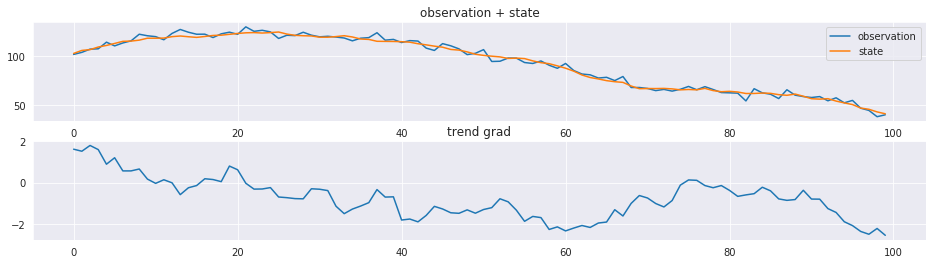

In [5]:
T = 100 # 時点数
x0 = np.array([100, 2]) # [初期状態の値、傾き], それぞれの値と対応する分散の大きさに注意

X = np.zeros((T, 2))
Y = np.zeros(T)

w = np.random.multivariate_normal(np.zeros(2), W_true, T)
v = np.random.normal(0, V_true**(1/2), T).reshape(-1,1) # 正規分布の引数は分散ではなく標準偏差なので注意

for t in range(T): # 色々考えたけど、行ベクトルでarrayを保存しているので、極力1次元arrayで処理した方が、列ベクトル行ベクトルを気にしなくて済む
    if t == 0:
        X[t] = G @ x0 + w[t]
        Y[t] = F @ X[t] + v[t]
    else:
        X[t] = G @ X[t-1] + w[t]
        Y[t] = F @ X[t] + v[t]
        
fig, axes = plt.subplots(nrows=2, figsize=(16, 4))
axes[0].plot(Y.flatten(), label='observation')
axes[0].plot(X[:,0], label='state')
axes[1].plot(X[:,1])

axes[0].set_title("observation + state")
axes[1].set_title("trend grad")
axes[0].legend()

plt.show()

## 関数の設定

In [6]:
def kalman_filter(m, C, y, W, V, G=G, F=F):
    """
    Kalman Filter
    m: 時点t-1のフィルタリング分布の平均
    C: 時点t-1のフィルタリング分布の分散共分散行列
    y: 時点tの観測値
    """
    a = G @ m
    R = G @ C @ G.T + W
    f = F @ a
    Q = F @ R @ F.T + V
    # 逆行列と何かの積を取る場合は、invよりsolveを使った方がいいらしい
    K = (np.linalg.solve(Q.T, F @ R.T)).T
    # K = R @ F.T @ np.linalg.inv(Q)
    m = a + K @ (y - f)
    C = R - K @ F @ R
    return m, C, a, R

In [7]:
def backward_sampling(x, m, C, a, R, G=G):
    """
    Backward Sampling
    """
    # 平滑化利得の計算
    A = np.linalg.solve(R, C @ G.T)
    # A = C @ G.T @ np.linalg.inv(R)
    # 状態の更新
    h = m + A @ (x - a)
    H = C - A @ R @ A.T
    x = np.random.multivariate_normal(h, H, 1)
    return x

In [8]:
def infer_mu(X, Sigma, m_b, W_b):
    """
    モデルに平均未知分散既知の多変量正規分布を仮定した時のパラメータ更新式
    X(N, D): データ
    Sigma(D, D): データの分散
    """
    assert X.ndim == 2, print("X must be 2 dim")
    N = X.shape[0]
    Lambda_x = np.linalg.inv(Sigma)
    Lambda_mu_b = np.linalg.inv(W_b)
    W_a = np.linalg.inv(N * Lambda_x + Lambda_mu_b)
    m_a = W_a @ (Lambda_x @ np.sum(X, axis=0) + Lambda_mu_b @ m_b)
    return m_a, W_a

In [9]:
def infer_m0(X0, W_x, m_b, W_b):
    assert X0.ndim == 1, print("X0 must be 1dim")
    X = X0.reshape(1, -1)
    return infer_mu(X, W_x, m_b, W_b)

In [10]:
def init_kalman_params(T):
    kp = dict()
    kp["m"] = np.zeros((T, 2))
    kp["C"] = np.zeros((T, 2, 2))
    kp["a"] = np.zeros((T, 2))
    kp["R"] = np.zeros((T, 2, 2))
    return kp

## 初期値の設定

In [11]:
# パラメータの事前分布のパラメータ
pr_params = dict()
pr_params["m0"] = {"m": np.zeros(2), "W": np.eye(2)}
# 固定値
W = W_true
V = V_true
C0 = np.diag([1, 1]) # ここを真値 or np.eye(2)にすると上手くいく
# MCMC初期値の設定
## 事前分布から発生させる方法もある？かもだけど、いい感じの初期値を恣意的に設定する
## まずは、理想値と同じ値
m0_0 = np.zeros(2)

## 実行

In [28]:
I = 50000 # サンプリング回数

# サンプリング結果を格納するdict
chains = dict()
chains["m0"] = np.zeros((I, 2))
chains["C0"] = np.zeros((I, 2, 2))
chains["X"] = np.zeros((I, T, 2))
chains["X0"] = np.zeros((I, 2)) # 初期状態はindexの都合上Xと分ける

# パラメータの事後分布のパラメータを格納するdict
po_params = dict()
po_params["m0"] = {"m": np.zeros((I, 2)), "W": np.zeros((I, 2, 2))}

In [ ]:
for i in tqdm(range(I)):
    # パラメータを固定
    if i == 0:
        m0 = m0_0
    else:
        m0 = chains["m0"][i-1]
    
    # FFBS
    ## カルマンフィルタ
    kp = init_kalman_params(T)
    for t in range(T):
        (m, C) = (m0, C0) if t == 0 else (kp["m"][t-1], kp["C"][t-1])
        kp["m"][t], kp["C"][t], kp["a"][t], kp["R"][t] = kalman_filter(m, C, Y[t], W, V)
    ## 時点Tの状態xを(m_t, C_t)からサンプリング
    chains["X"][i, T-1] = np.random.multivariate_normal(kp["m"][T-1], kp["C"][T-1], 1)
    ## 時点1:T-1の状態xを逆向きにサンプリング
    for t in range(T-1):
        t = (T - 1) - t - 1
        chains["X"][i, t] = backward_sampling(chains["X"][i, t+1], kp["m"][t], kp["C"][t], kp["a"][t+1], kp["R"][t+1])
    ## 時点0の状態xを逆向きにサンプリング
    chains["X0"][i] = backward_sampling(chains["X"][i, 0], m0, C0, kp["a"][0], kp["R"][0])
    
    # パラメータの事後分布のパラメータを更新
    ## 事前分布のパラメータの設定
    if i == 0:
        m_b = pr_params["m0"]["m"]
        W_b = pr_params["m0"]["W"]
    else:
        m_b = po_params["m0"]["m"][i-1]
        W_b = po_params["m0"]["W"][i-1]
    
    ## 更新と格納
    m_a, W_a = infer_m0(chains["X0"][i], W, m_b, W_b)
    po_params["m0"]["m"][i] = m_a
    po_params["m0"]["W"][i] = W_a
    
    ##事後分布からパラメータをサンプリング
    chains["m0"][i] = np.random.multivariate_normal(po_params["m0"]["m"][i], po_params["m0"]["W"][i])

/home/uchide/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()


In [33]:
x0

array([100,   2])

In [34]:
for i in range(0, 49901, 1000):
    print(chains["m0"][i:].mean(axis=0))

[83.76700488  0.93581094]
[84.13925194  0.95470386]
[84.34905814  0.96620527]
[84.51399644  0.9765555 ]
[84.65480579  0.98295992]
[84.77802553  0.9889472 ]
[84.88903059  0.99390337]
[84.98954121  1.00057259]
[85.08204167  1.00745843]
[85.16807734  1.01387254]
[85.2497241   1.01746857]
[85.32684836  1.02042249]
[85.40017942  1.02275705]
[85.4696223   1.02526101]
[85.53557488  1.02766802]
[85.59886955  1.02921805]
[85.65979049  1.03005446]
[85.71866639  1.0299529 ]
[85.7749871  1.0307644]
[85.82901416  1.03208862]
[85.88137952  1.03291795]
[85.93218714  1.03324138]
[85.98065817  1.0351492 ]
[86.02700546  1.03852018]
[86.07183299  1.0422766 ]
[86.11584868  1.04480837]
[86.15948998  1.04522201]
[86.20225995  1.04489716]
[86.24356284  1.04531758]
[86.28363316  1.04625085]
[86.32163061  1.04962695]
[86.35877423  1.05271097]
[86.39547368  1.05476402]
[86.43181538  1.05541432]
[86.46704474  1.0567467 ]
[86.50130807  1.05837208]
[86.53442771  1.06121902]
[86.56689203  1.06413203]
[86.59864582  

m0の値がchainを増すごとに上がっている

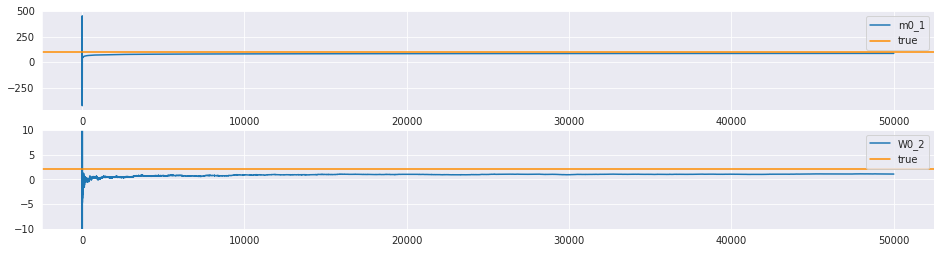

In [35]:
# chainと真値を比較
fig, axes = plt.subplots(nrows=2, figsize=(16, 4))
axes[0].plot(chains["m0"][:,0], label="m0_1")
axes[1].plot(chains["m0"][:,1], label="W0_2")

axes[0].axhline(x0[0], color="darkorange",  label="true")
axes[1].axhline(x0[1], color="darkorange", label="true")

axes[1].set_ylim(-10, 10)

axes[0].legend()
axes[1].legend()

plt.show()

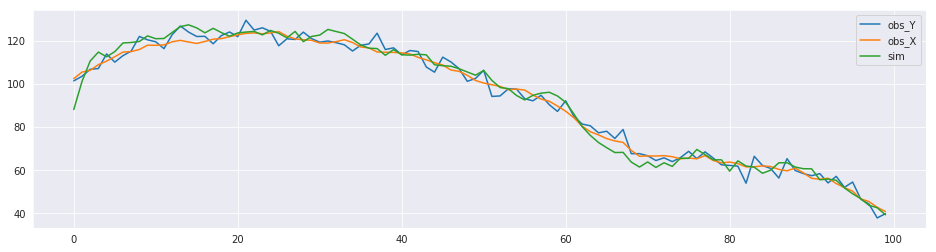

In [36]:
# 観測雑音vについて調べる
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(Y, label="obs_Y")
ax.plot(X[:,0], label="obs_X")
ax.plot((F @ chains["X"][i].T).flatten(), label="sim")
ax.legend()
plt.show()

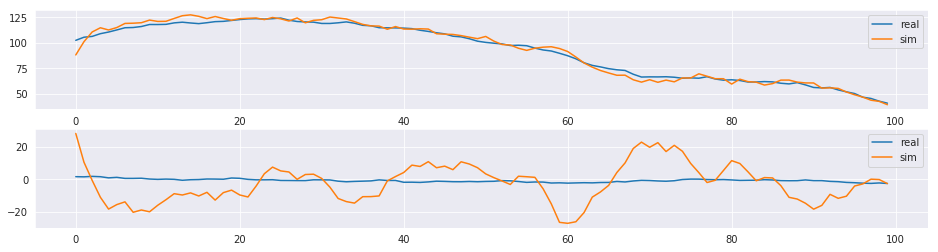

In [37]:
# 状態の当てはまりについて調べる
fig, axes = plt.subplots(nrows=2, figsize=(16, 4))
axes[0].plot(X[:,0], label="real")
axes[0].plot(chains["X"][i][:,0], label="sim")
axes[1].plot(X[:,1], label="real")
axes[1].plot(chains["X"][i][:,1], label="sim")
axes[0].legend()
axes[1].legend()
plt.show()

カルマンフィルタの時もそうだったけど、レベル成分についてはだいたいフィッティングに失敗する  
ある程度の誤差は気にしない、計算が発散しない事を第一に据える  

In [38]:
pred_x = np.vstack([chains["X0"][i], chains["X"][i][:-1]]) @ G.T
real_x = chains["X"][i]

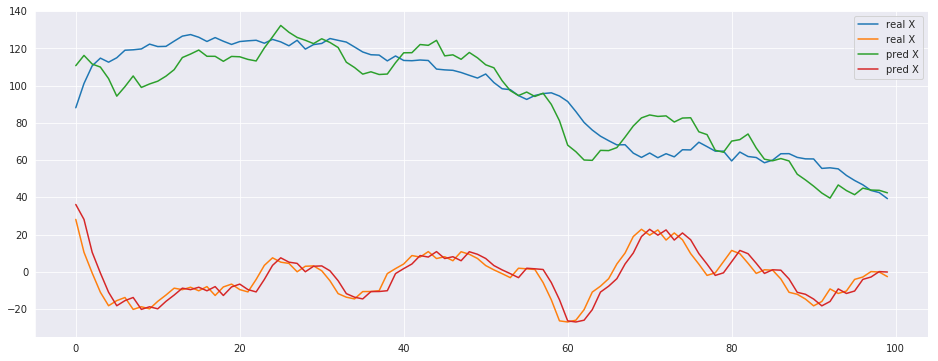

In [39]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(real_x, label="real X")
ax.plot(pred_x, label="pred X")
ax.legend()
plt.show()

レベル成分が1時点ずれているのは、realの1時点前の値がpredの値になっているから